In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import scipy as sp

network output is defined as (pg 547):

$$z(t) = \mathbf{w}^T \mathbf{r}(t)$$

network error function (pg 547):

$$e_-(t) = \mathbf{w}^T(t - \Delta t)\mathbf{r}(t) - f(t)$$

nb! this is the error right before the weights are updated at time t. The idea is to update the weights from $\mathbf{w}(t-\Delta t) \text{ to } \mathbf{w}(t)$ in such a way as to reduce the magnitude of $e_-(t)$

So, immediately after the weight update, the netwrok output, **z**, is $\mathbf{w}^T(t)\mathbf{r}(t)$, if the weights are updated fast enough.

So, the error __after__ the weight update is $$ e_+(t) = \mathbf{w}^T(t) \mathbf{r}(t) - f(t) $$


THE goal, then, is to reduce errors in the network by making $$|e_+(t)| < |e_-(t)|$$ and converging to a solution so that the weight vecotr no longer needs to be updated (pg. 548)

this means that $$\frac{e_+(t)}{e_-(t)} \rightarrow 1$$ by the end of training (pg 548)

accomplished by steady but small reduction in $e_-$ and $e_+$ over time, except for the first update which is large (pg 548). So you also want to have $\Delta t$ be pretty short to accomplish this

## Recursive Least Squares

(Why?)

RLS: $$\mathbf{w}(t) = \mathbf{w}(t - \Delta t) - e_-(t) \mathbf{P}(t) \mathbf{r}(t)$$

where **P** is an NxN matrix that is updated at the same time as the weights according to the rule: 
$$\mathbf{P}(t) = \mathbf{P}(t - \Delta t) - \frac{\mathbf{P}(t - \Delta t) \mathbf{r}(t) \mathbf{r}^T \mathbf{P}(t - \Delta t)}{1 + \mathbf{r}^T(t)\mathbf{P}(t - \Delta t) \mathbf{r}(t)}$$

Where $$\mathbf{P}(0) = \frac{\mathbf{I}}{\alpha}$$
Where **I** is the identity matrix, and $\alpha$ is a constant (pg. 548)

Where **P** acts a a multidimensional learning rate for the 'delta' type learning rule. So, for this algorithm, **P** is a "Running estimate  of the inverse of teh correlation matrix of the network rates **r** plus a regularization term: $$\mathbf{P} = \left( \sum_t \mathbf{r}(t)\mathbf{r}^T(t) + 
\alpha \mathbf{I} \right)$$

For subsequent timesteps, the equation above imply that: $$e_+(t) = e_-(t)(1 - \mathbf{r}^T (t) \mathbf{P}(t)\mathbf{r}(t))$$
(pg 548) so the quantity $\mathbf{r}^T\mathbf{P}\mathbf{r}$ varies from around 1 to assymptotically approaching 0 over the course of training, and is always positive

$\alpha$ acts as the learning rate, and should be adjusted depending on the target function. (pg548). small values for $\alpha$ result in fast learning but sometimes can become unstable. But, if $\alpha$ is too big, FORCE might not be able to keep the output close to the target for long enough. use between 1 and 100 (pg 548)

Learning generally takes about $1000 \tau$ where $\tau$ is the basic time constant of the network, which they set to around 10ms. So basically it takes around 10 seconds of simulated time for teh network to converge (549)

"To encompass all the models, we write the newtwork equations for the generator network as: 
$$\tau \frac{dx_i}{dt} = -x_i + g_{GG} \sum_{j = 1}^{N_G}J_{ij}^{GG} r_j + g_{G_z} J_{i} ^{G_z} z + g_{GF} \sum_{a = 1}^{N_F} J_{ia}^{GF} s_a + \sum_{\mu = 1}^{N_I} J_{i \mu}^{GI} I_\mu$$

for $i = 1, 2, .. <1,2,..>, N_G$ with firing rates $r_i = \tanh(x_i$) (pg 556)

For figure 2 and 3, the parameters are:

$$N_G = 1000\\
p_{GG} = 0.1\\
p_Z = 1\\
g_{GG} = 1.5\\
g_{Gz} = 1\\
g_{GF} = 0\\
\alpha = 1.0\\
N_I = 0\\
\tau = 10ms$$

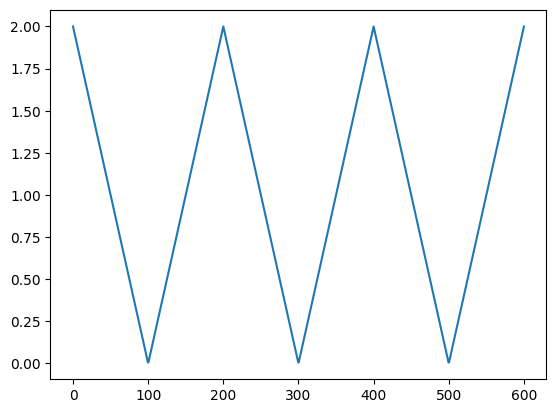

In [223]:
t = np.linspace(0, 600, 1000)
triangle = -signal.sawtooth(2 * np.pi * 5 * t, 0.5) + 1
plt.plot(t, triangle)

In [3]:
alpha = 1.0
P_init = np.identity(1000)/alpha
timesteps = 600
dt = 0.1

In [196]:
func_to_aprox = triangle
initial_Matrix = np.random.rand(1000) * 1.5
wf = 2.0  * (np.random.rand(1000) - 0.5)#wtf?
neurons = 0.5 * np.random.rand(1000)
weights = np.zeros(1000)
readout_init = 0.5 * np.random.rand(1)

In [10]:
np.zeros(1000).T @ np.tanh(0.5 * np.random.rand(1000))

0.0

In [284]:
class GeneratorNetwork:
    def __init__(self, N, alpha, g, func_to_aprox, timesteps):
        self.timesteps = timesteps
        self.neurons = 0.5 * np.random.rand(N, 1)
        self.delta = 0.1
        self.alpha = alpha
        self.P = np.identity(N)/self.alpha
        self.output = np.zeros(self.timesteps)
        self.evol = np.zeros(self.timesteps)
        self.initial_Matrix = np.random.rand(N, 1) * g
        self.wf = 2.0 * (np.random.rand(N, 1) - 0.5)
        self.weights = np.zeros(N)
        self.neurons = 0.5 * np.random.rand(N, 1)
        self.func_to_aprox = func_to_aprox
        

    def network_output(self, weights, neurons):
        return weights.T @ np.tanh(neurons)
    
    def inverse_corr_matrix_estimate_update(self, P, neurons):
        return P - (P @ neurons @ neurons.T @ P)/(1 + neurons.T @ P @ neurons)
    
    def get_error(self, readout, timestep):
        return readout - self.func_to_aprox[timestep]
    
    def weight_update(self, weights, error, P, neurons):
        return weights - error * P @ neurons

    def neuron_update(self, neurons, output):
        return (1.0 - self.delta) * neurons + self.initial_Matrix * (np.tanh(neurons) * self.delta) + self.wf * (output * self.delta)

    def train(self):
        self.neurons = self.neuron_update(self.neurons, self.network_output(weights, self.neurons))
        
        evolution = np.zeros(self.timesteps)

        for time in range(self.timesteps):    
            self.P = self.inverse_corr_matrix_estimate_update(self.P, self.neurons)
            self.weights = self.weight_update(self.weights, self.get_error(self.network_output(weights, self.neurons), time), self.P, self.neurons)
            self.output[time] = self.network_output(self.weights, self.neurons)[0]
            evolution[time] = self.output[time]
            self.neurons = self.neuron_update(self.neurons, self.network_output(weights, self.neurons))
        return evolution


        


In [ ]:
x = (1.0 - 0.1) * np.random.rand((1000,1000))

In [285]:
x = GeneratorNetwork(1000, 1.0, 1.5, triangle, 600)

In [294]:
results = x.train()

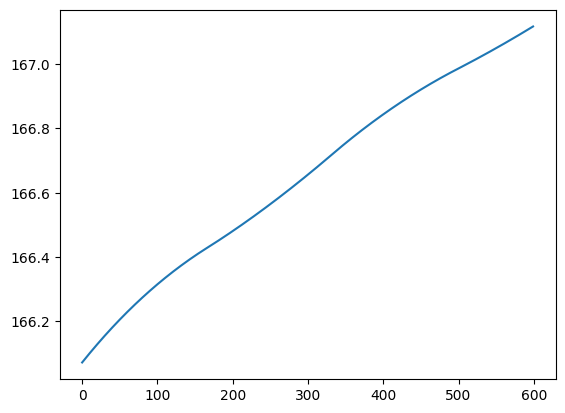

In [295]:
plt.plot(results)

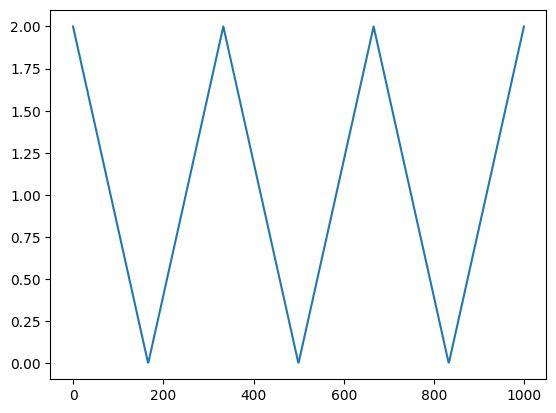

In [227]:
plt.plot(triangle)

## Let's try something else

In [301]:
w = np.random.rand(1000,1)
r = np.random.rand(1000,1)

output = w.T @ r

output[0][0]

257.4744154382098

In [302]:
error = w.T @ r - triangle[0]

In [310]:
P_init = np.identity(1000)/1.0
P = P_init - (P_init @ r @ r.T @ P_init)/(1 + r.T @ P_init @ r)

In [312]:
updated_weight = w - error * P @ r

In [314]:
updated_weight.shape

(1000, 1)

In [337]:
def output(weights, neurons):
    return weights.T @ np.tanh(neurons)

def error(output, function, timestep):
    return output - function[timestep]

def weight_update(weights, error, P, neurons):
    return weights - error * P @ neurons

def P_update(P, neurons):
    return P - (P @ neurons @ neurons.T @ P)/(1 + neurons.T @ P @ neurons)

def neuron_update(neurons):
    return (1.0 - 0.1) * neurons + 1.5 * ((neurons) * 0.1) + 2.0 * (output(weights, neurons) * 0.1) 


ns = np.random.rand(1000, 1) * 0.5
ws = np.random.rand(1000, 1) * 0.5

In [445]:
class GenNetv2:
    def __init__(self, N, alpha, g, p, delta):
        # attributes from setup
        self.N = N
        self.alpha = alpha
        self.g = g
        self.p = p
        self.delta = delta
        self.random_state = np.random.default_rng()

        # general network attributes
        self.P = np.identity(N)/self.alpha
        self.weights = np.random.rand(N, 1) * 0.5
        self.neurons = np.random.rand(N, 1) * 0.5
        self.output = np.random.rand(1, 1) * 0.5
        self.M = np.random.rand(N, N) * self.g * 1.0 / np.sqrt(self.p * self.N)
        self.wf = 2.0 * (np.random.rand(N, 1) - 0.5)
        self.error = 0.0
        self.activation = np.tanh(self.neurons)

    #Helper functions
    def neuron_activity(self):
        return (1.0 - self.delta) * self.activation + self.M @ (self.activation * self.delta) + self.wf * (self.output * self.delta)
    
    def net_output(self):
        return self.weights.T @ self.activation
    
    def get_error(self, function, timestep):
        return self.output - function[timestep]
    
    def weight_update(self):
        self.weights = self.weights - self.error * self.P @ self.activation

    def P_update(self):
        self.P = self.P - (self.P @ self.activation @ self.activation.T @ self.P)/(1 + self.activation.T @ self.P @ self.activation)

    def spontaneus_activity
    
    #training the network
    def train(self, function, timesteps):
        func_to_approx = function 
        evolution = np.zeros(timesteps)
        evolution[0] = self.output
        self.neurons = self.neuron_activity()
        
        for time in range(1, timesteps):
            self.error = self.get_error(func_to_approx, time)
            self.P_update()
            self.weight_update()
            self.output = self.net_output()
            evolution[time] = self.output
            self.neurons = self.neuron_activity()

        return evolution

In [446]:
y = GenNetv2(1000, 1, 1.5, 0.1, 0.1)

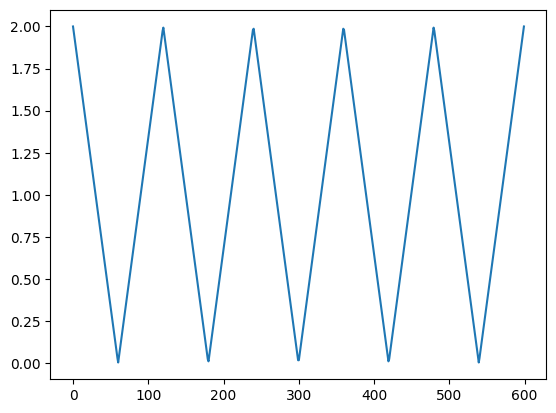

In [461]:
t = np.linspace(0, 600, 600)
triangle = -signal.sawtooth(2 * np.pi * 5 * t, 0.5) + 1
plt.plot(triangle)

In [447]:
for epoch in range(1):
    results = y.train(triangle, 600)

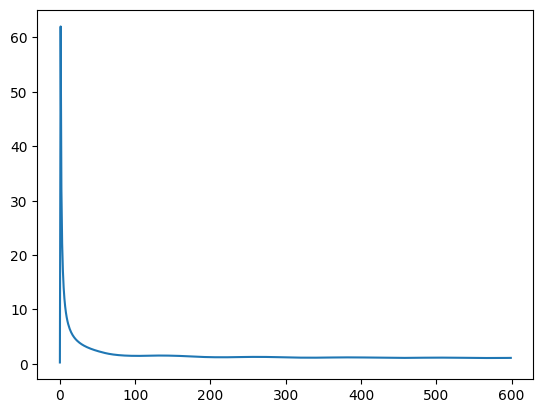

In [448]:
plt.plot(np.arange(600), results)

In [420]:
results[1]

99.823039043156